$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/glassman/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/glassman/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/glassman/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


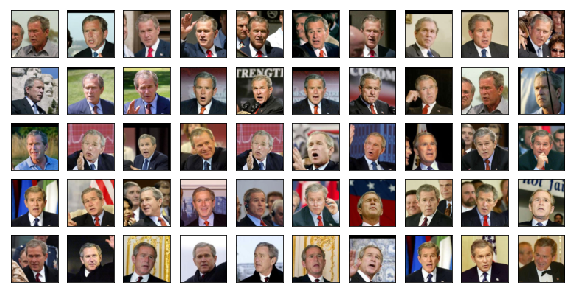

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [16]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (16): BatchNorm2d(512, eps=1e-05, momentum

**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [17]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (seq): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [18]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [19]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-5)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients.

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

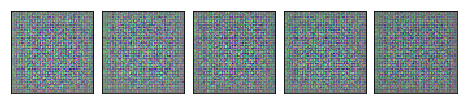

In [20]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [43]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'weight_decay': 0.001, 'betas': (0.5, 0.999), 'lr': 0.0001}, 'generator_optimizer': {'type': 'Adam', 'weight_decay': 0.001, 'betas': (0.5, 0.999), 'lr': 0.0001}}


--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.66it/s]
Discriminator loss: 0.2104850661228685
Generator loss:     5.232235277400298


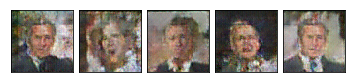

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.98it/s]
Discriminator loss: 0.23571953703375423
Generator loss:     5.371320724487305


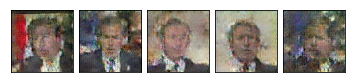

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.73it/s]
Discriminator loss: 0.22443616872324662
Generator loss:     6.22440432099735


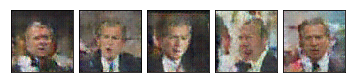

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.70it/s]
Discriminator loss: 0.16487004333997474
Generator loss:     5.709871909197639


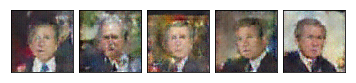

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.55it/s]
Discriminator loss: 0.19601186014273586
Generator loss:     5.630541941698859


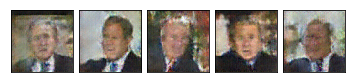

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 0.19025547002606533
Generator loss:     5.7892750852248245


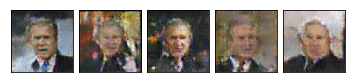

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Discriminator loss: 0.1917685342623907
Generator loss:     5.775272818172679


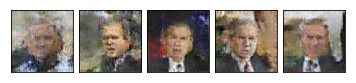

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.15585733489955172
Generator loss:     6.1006456262925095


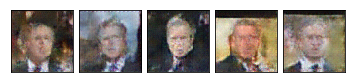

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Discriminator loss: 0.19561865969615824
Generator loss:     5.675936656839707


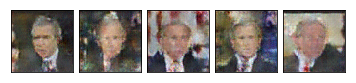

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 0.20650859527728138
Generator loss:     6.099901732276468


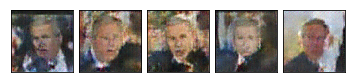

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.82it/s]
Discriminator loss: 0.17880899196161942
Generator loss:     6.0154531703275795


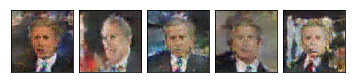

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.98it/s]
Discriminator loss: 0.1536852005211746
Generator loss:     6.2796140278086945


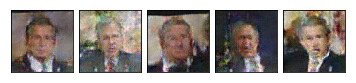

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.25it/s]
Discriminator loss: 0.14641955319572897
Generator loss:     6.12741086062263


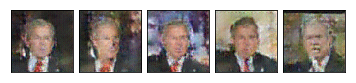

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.93it/s]
Discriminator loss: 0.18422164307797656
Generator loss:     6.318891553317799


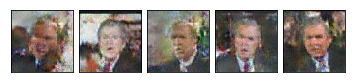

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.88it/s]
Discriminator loss: 0.1644474467372193
Generator loss:     6.447155559764189


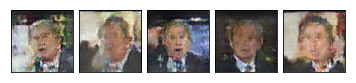

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.21it/s]
Discriminator loss: 0.1284379601916846
Generator loss:     6.709622635560877


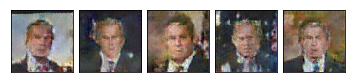

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 0.13761782514698365
Generator loss:     6.5783331674688


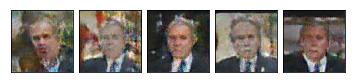

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.95it/s]
Discriminator loss: 0.2822633262942819
Generator loss:     6.204679741578944


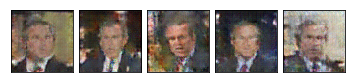

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.79it/s]
Discriminator loss: 0.13365542921511567
Generator loss:     6.124513990738812


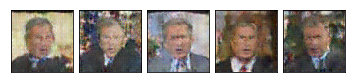

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 0.17097877612447038
Generator loss:     6.5844942822175865


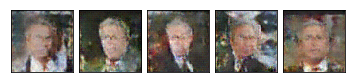

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.2048212929683573
Generator loss:     6.579410749323228


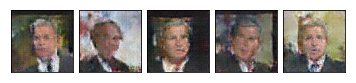

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.96it/s]
Discriminator loss: 0.17134850368122845
Generator loss:     6.317334932439468


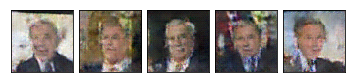

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 0.06852861712960635
Generator loss:     7.19891180711634


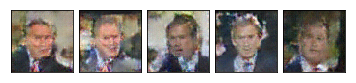

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Discriminator loss: 0.14982541343745062
Generator loss:     6.64442850561703


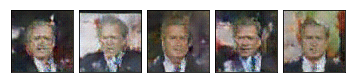

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.07it/s]
Discriminator loss: 0.1717278466505163
Generator loss:     7.029782337300918


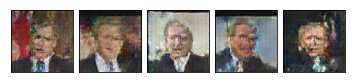

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Discriminator loss: 0.17784583995885708
Generator loss:     7.180853899787454


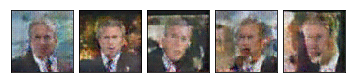

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.89it/s]
Discriminator loss: 0.15919926105176702
Generator loss:     6.810590519624598


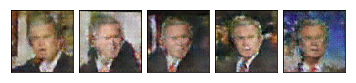

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.85it/s]
Discriminator loss: 0.12100651202832952
Generator loss:     7.038385082693661


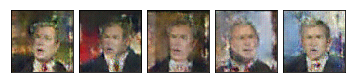

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 0.1525040772907874
Generator loss:     6.687205539030187


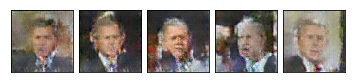

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.85it/s]
Discriminator loss: 0.17617460663485177
Generator loss:     6.836430689867805


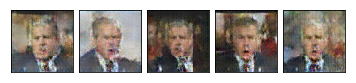

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.15it/s]
Discriminator loss: 0.0880723926512634
Generator loss:     7.559782729429357


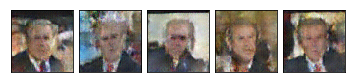

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.92it/s]
Discriminator loss: 0.17680789354969473
Generator loss:     6.578231755424948


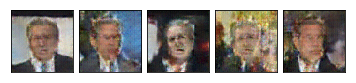

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.81it/s]
Discriminator loss: 0.1517919345813639
Generator loss:     6.868827875922708


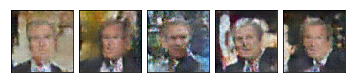

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.79it/s]
Discriminator loss: 0.19488725307233193
Generator loss:     6.9007936645956605


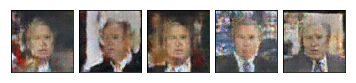

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 0.16586365813718124
Generator loss:     7.40082207848044


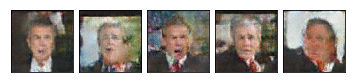

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.74it/s]
Discriminator loss: 0.14876083295573206
Generator loss:     6.559637013603659


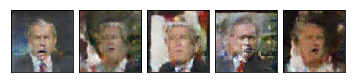

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.96it/s]
Discriminator loss: 0.11414158760624774
Generator loss:     7.437652812284582


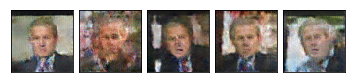

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.91it/s]
Discriminator loss: 0.21772026840378256
Generator loss:     6.340291331796085


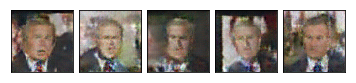

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.84it/s]
Discriminator loss: 0.18066350195337744
Generator loss:     6.721657360301299


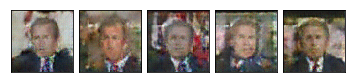

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.90it/s]
Discriminator loss: 0.1617299684268587
Generator loss:     6.625875697416418


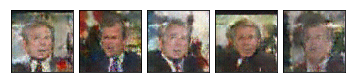

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.95it/s]
Discriminator loss: 0.19794127739527645
Generator loss:     6.804766739115996


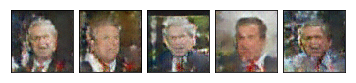

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.15it/s]
Discriminator loss: 0.17773300212095766
Generator loss:     7.329222679138184


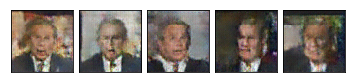

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 0.22234640796394908
Generator loss:     6.2571783346288345


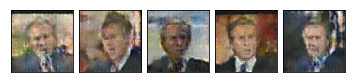

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.62it/s]
Discriminator loss: 0.18086633929873214
Generator loss:     6.378472636727726


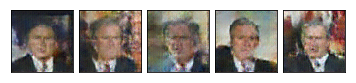

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 0.21271933461813367
Generator loss:     6.16764357510735


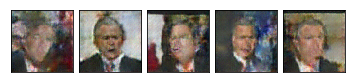

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.1407627404174384
Generator loss:     6.7020626909592576


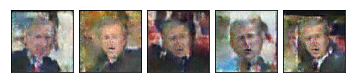

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.11332968490965226
Generator loss:     6.44600181018605


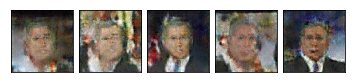

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Discriminator loss: 0.16300714750062018
Generator loss:     6.320674924289479


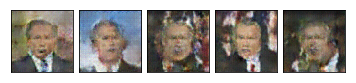

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
Discriminator loss: 0.1813364186707665
Generator loss:     7.128478386822869


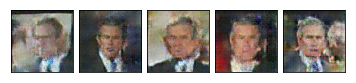

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.85it/s]
Discriminator loss: 0.23097476582316792
Generator loss:     6.670736172619988


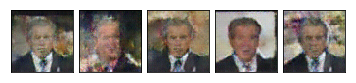

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.09786212477175628
Generator loss:     6.791717921986299


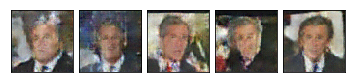

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Discriminator loss: 0.18331952568362742
Generator loss:     6.81852473932154


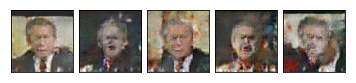

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.48it/s]
Discriminator loss: 0.2219028074075194
Generator loss:     6.671722145641551


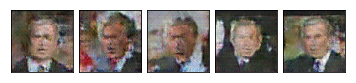

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.44it/s]
Discriminator loss: 0.22358783422147527
Generator loss:     6.139595171984504


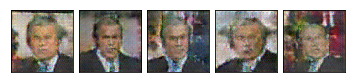

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.14912109000279622
Generator loss:     6.118021291844985


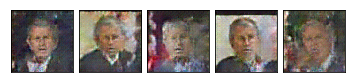

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.36it/s]
Discriminator loss: 0.12866726430023417
Generator loss:     6.610690229079303


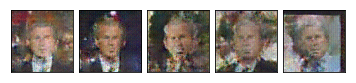

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.16428225388860002
Generator loss:     6.939194258521585


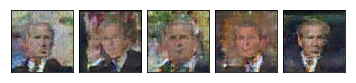

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.20538907454294317
Generator loss:     6.709279705496395


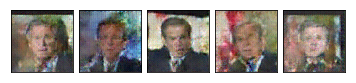

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Discriminator loss: 0.09481469224042752
Generator loss:     7.229408684898825


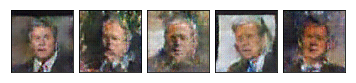

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.11453177516951281
Generator loss:     7.147596611696131


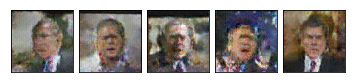

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 0.1828874570920187
Generator loss:     6.993250678567326


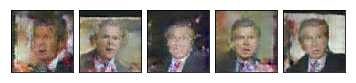

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.19it/s]
Discriminator loss: 0.12596495055100498
Generator loss:     7.3126621807322785


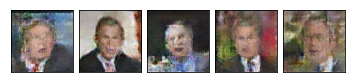

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.43it/s]
Discriminator loss: 0.17658651707803502
Generator loss:     7.251228052027085


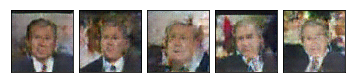

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.30it/s]
Discriminator loss: 0.10668047254576403
Generator loss:     7.212910539963666


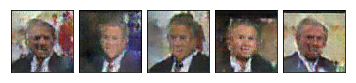

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.26it/s]
Discriminator loss: 0.08577550016343594
Generator loss:     7.160778606639189


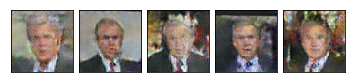

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Discriminator loss: 0.12293543053023956
Generator loss:     7.144527182859533


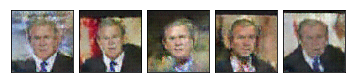

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.49it/s]
Discriminator loss: 0.16996412789996931
Generator loss:     7.528690534479478


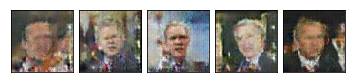

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.19it/s]
Discriminator loss: 0.07860983338426142
Generator loss:     7.814025037428912


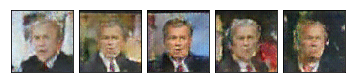

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.29it/s]
Discriminator loss: 0.24334019137655988
Generator loss:     6.152402120478013


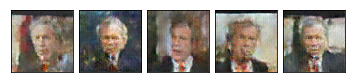

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.94it/s]
Discriminator loss: 0.14791723077788071
Generator loss:     7.22919433257159


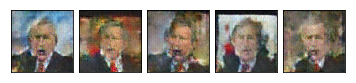

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Discriminator loss: 0.31150157661998973
Generator loss:     6.812634103438434


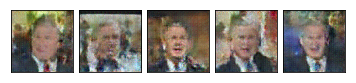

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.10162635542014066
Generator loss:     7.010197695563821


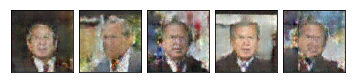

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Discriminator loss: 0.1518172966864179
Generator loss:     7.004276696373434


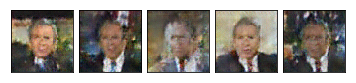

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.16it/s]
Discriminator loss: 0.18425019282628508
Generator loss:     7.0809484650106995


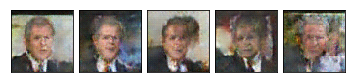

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Discriminator loss: 0.15221571615513632
Generator loss:     7.240997538847082


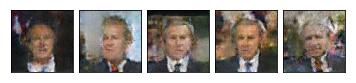

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 0.15491124527419314
Generator loss:     6.776064620298498


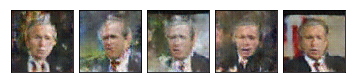

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.28it/s]
Discriminator loss: 0.139634500750724
Generator loss:     7.009880262262681


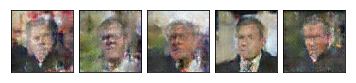

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.30it/s]
Discriminator loss: 0.1963846289059695
Generator loss:     7.163768768310547


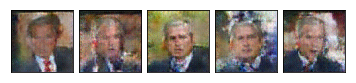

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.1572239850373829
Generator loss:     6.720290604759665


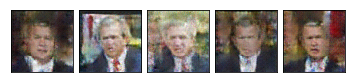

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.98it/s]
Discriminator loss: 0.12188968719804988
Generator loss:     7.252727592692656


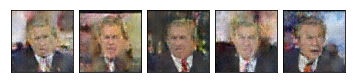

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.30it/s]
Discriminator loss: 0.12670191300704198
Generator loss:     6.667434972875259


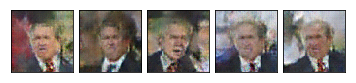

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 0.11248969527728417
Generator loss:     7.198457044713638


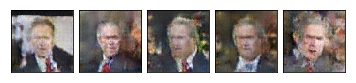

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Discriminator loss: 0.11614164206034996
Generator loss:     7.2386157933403465


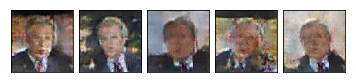

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.15769422865089247
Generator loss:     7.224797809825224


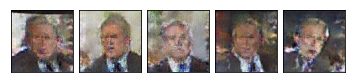

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.11265083753010806
Generator loss:     8.062072473413805


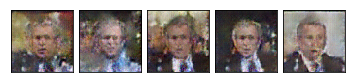

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 0.1909891370245639
Generator loss:     7.273121020373176


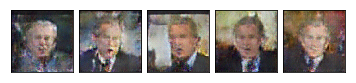

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.95it/s]
Discriminator loss: 0.0711965941111831
Generator loss:     7.398668092839858


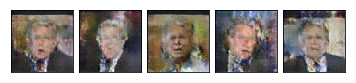

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.11818586498060647
Generator loss:     7.55328192430384


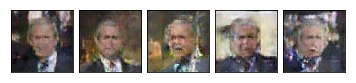

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.90it/s]
Discriminator loss: 0.12663840223103762
Generator loss:     8.232169067158418


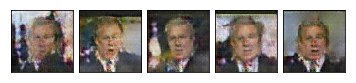

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.72it/s]
Discriminator loss: 0.09800472110509872
Generator loss:     7.852265947005328


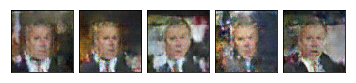

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
Discriminator loss: 0.19031105826006217
Generator loss:     7.519415602964513


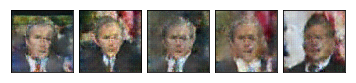

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.87it/s]
Discriminator loss: 0.11785269178011838
Generator loss:     7.5413768151227165


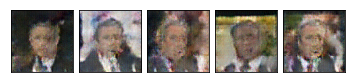

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 0.18558044841184335
Generator loss:     8.440010014702292


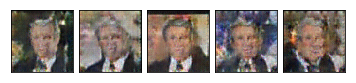

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.82it/s]
Discriminator loss: 0.20992926858803806
Generator loss:     8.222050610710593


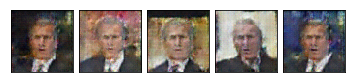

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.95it/s]
Discriminator loss: 0.20124570784323356
Generator loss:     7.81480006610646


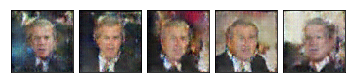

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.83it/s]
Discriminator loss: 0.1217698459239567
Generator loss:     7.88374912037569


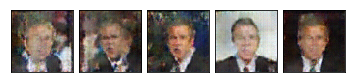

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 0.18535523883560123
Generator loss:     7.8992780236636895


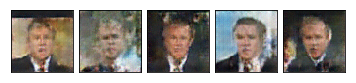

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 0.053624547798843944
Generator loss:     7.6726537872763245


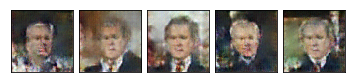

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.21it/s]
Discriminator loss: 0.12148237206480082
Generator loss:     7.971524743472829


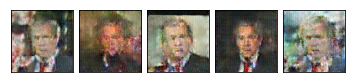

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Discriminator loss: 0.17740684627171824
Generator loss:     7.747653961181641


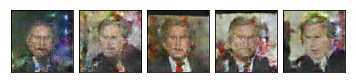

In [54]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


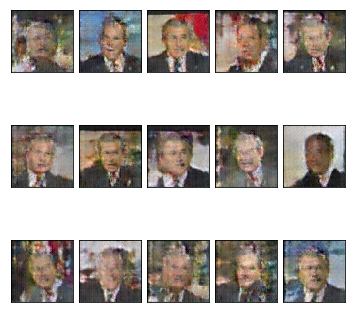

In [53]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [46]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [47]:
display_answer(hw3.answers.part3_q1)


**Your answer:**

We have to maintain the gradient when sampling from the GAN when we are sampling in the batch training function.
The reason is that when we are training we want the gradient so that we can optimize the result of the generator. In all other occasions we do not maintain the gradient so that we will not change its value and ruine the training.


### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [48]:
display_answer(hw3.answers.part3_q2)


**Your answer:**
We can't decide to stop training based on the generator loss being bellow a certain threshold because the loos of the generator and the loss of the descriminator are connected. We can imagine a situation where the loss of the generator is very low (so we would think to stop training) but in the next batch the descriminator will sudenlly improve and find new differences between the real and fake images therefore the loss of the generator will go back up. If we get into a situation where the loss of the descriminator is constant but the loos of the generator keeps improving then we are in a situation where the descriminator can no longer tell the difference between the real and fake images but the generator keeps making the images better and better in comparison to the real ones.



### Question 2

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [49]:
display_answer(hw3.answers.part3_q3)


**Your answer:**
The GAN is divided in two parts that compete against each other. The generator tries to construct a realistic image, while the discriminator tries to find out if the image is real or not. This permits a better training in order to obtain images that are more similar to the specific real ones that come from the training set. For this reason, the results of the GAN are better overall images in terms of the background for example. The goal is to reconstruct images that look as similar as possible to the dataset.
On the other hand, the VAE aims to sample images from the label space, that is to reconstruct images from a prior distribution. We assume that the instances can be reconstruct from a latent space with smaller dimension and we want to learn through the VAE the main characteristics of the images in the dataset. Thus, even if the pictures are blurry, it captures the main characteristics of a face in each sample.

